This notebook includes code cells for creating various graphs and plots for the techno-economic analysis of the production of linear-alpha olefins from biologically derived fatty alcohols.

Before runnning any analysis, first run the following cell:

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')
from biosteam.process_tools import UnitGroup
from biosteam.digraph import digraph_from_units, save_digraph
from biosteam.utils import streams_from_units, filter_out_missing_streams, colors
from biosteam.report import unit_result_tables, tables_to_excel, stream_table
import biorefineries.LAOs as ol
import numpy as np
import biosteam as bst
from biosteam.utils import colors
from biorefineries.LAOs import specs, LAOs_tea, LAOs_sys, unit_groups, get_LAOs_MPSP, hexene, octene, decene
from matplotlib import pyplot as plt
import pandas as pd
from biosteam.plots import plot_contour_2d, MetricBar, CABBI_green_colormap, plot_scatter_points, plot_contour_1d
from math import floor, ceil

million_dollar = r"\mathrm{MM\$}"
MPSP_units = r"$\mathrm{\$} \cdot \mathrm{ton}^{-1}$"
productivity_units = "$\mathrm{g} \cdot \mathrm{L}^{-1} \cdot \mathrm{hr}^{-1}$"
VOC_units = MPSP_units
# FCI_units = MPSP_units
# VOC_units = "$" + million_dollar + r"\cdot \mathrm{yr}^{-1}$"
FCI_units = f"${million_dollar}$"
duty = r"GJ\cdot hr^{-1}"
products = (hexene, octene, decene)

def tickmarks(data, accuracy=50, N_points=5):
    dmin = data.min()
    dmax = data.max()
    dmin = floor(dmin/50) * 50
    dmax = ceil(dmax/50) * 50
    step = (dmax - dmin) / (N_points - 1)
    return [dmin + step * i for i in range(N_points)]

areas = {
    'Fermentation': (ol.T102, ol.P102, ol.M102, ol.H101, ol.R101, ol.T105, ol.P104, ol.CCI),
    '3-Phase Decanter': (ol.C101, ol.P107),
    'Dehydration': (ol.H102, ol.M103, ol.H103, ol.H105, ol.R102),
    'Separation': (ol.P105, ol.C102, ol.P106, ol.H104, ol.D101,
                   ol.D102, ol.M104, ol.M105, ol.P108, ol.C103, ol.P109,
                   ol.H106, ol.H107, ol.H108, ol.H109, ol.D103, ol.D104),
    'OSBL': (ol.T101, ol.T104, ol.T103, ol.T106, ol.T108, ol.T109, ol.T110,
             ol.CT, ol.BT, ol.CWP, ol.T107),
}

area_groups = [UnitGroup(i, j) for i,j in areas.items()]
area_groups.append(UnitGroup('Total', sum(areas.values(), ())))

LAO_price_range = [1077, 1427]
target_yield = 80
target_titer = 40
target_productivity = 0.5
target_dehydration_mass_fraction = 20
target_dehydration_conversion = 100
lab_yield = 50
lab_titer = 4.5
lab_productivity = 0.1

get_LAOs_VOC = lambda: LAOs_tea.VOC / 1e6 # million USD / yr
get_LAOs_FCI = lambda: LAOs_tea.FCI / 1e6 # million USD
olefin_metrics = [get_LAOs_MPSP, get_LAOs_VOC, get_LAOs_FCI]

shadecolor = (*colors.neutral.RGBn, 0.30)
linecolor = (*colors.neutral_shade.RGBn, 0.85)
markercolor = (*colors.CABBI_blue_light.RGBn, 1)
edgecolor = (*colors.CABBI_black.RGBn, 1)

def set_target_specifications():
    specs.run_specifications(
        fermentation_yield=target_yield / 100,
        fermentation_titer=target_titer,
        fermentation_productivity=target_productivity,
        dehydration_reactor_conversion=target_dehydration_conversion / 100,
        dehydration_reactor_mass_fraction=target_dehydration_mass_fraction / 100,
    )

def set_baseline_specifications():
    specs.run_specifications(
        fermentation_yield=lab_yield / 100,
        fermentation_titer=lab_titer,
        fermentation_productivity=lab_productivity,
        dehydration_reactor_conversion=target_dehydration_conversion / 100,
        dehydration_reactor_mass_fraction=target_dehydration_mass_fraction / 100,
    )
set_target_specifications()

In [ ]:
get_LAOs_MPSP()
# Reaction (by wt):
# stoichiometry                                      reactant    X[%]
# Glucose -> 0.15 Water + 0.361 Octanol + 0.489 CO2  Glucose    90.00
#
# ol.R102.reaction[1].copy('wt')
# Reaction (by wt):
#  stoichiometry                          reactant    X[%]
#  Octanol -> 0.138 Water + 0.862 Octene  Octanol    90.00

# Minimum price of product assuming glucose is magically converted to product: 
# (236 USD / ton) / (0.361 * 0.9) / 0.862 = 843 USD /ton

Save tables if the TEA and graphs of the process:

In [ ]:
# Save tables
from biorefineries.LAOs import capex_table, voc_table, foc_table
tables = {
    'CAPEX': capex_table(LAOs_tea),
    'VOC': voc_table(LAOs_sys, LAOs_tea, products),
    'FOC.xlsx': foc_table(LAOs_tea),
}
with pd.ExcelWriter('results/Capital and operating costs [target].xlsx') as writer:
    tables_to_excel(tables.values(), writer, sheet='Capital and operating costs')


In [ ]:
# Save stream tables and graphs by unit group
with pd.ExcelWriter("results/Stream tables.xlsx") as writer:
    for name, units in areas.items():
        f = digraph_from_units(units)
        save_digraph(f, 'results/' + name, 'png')
        streams = streams_from_units(units)
        filter_out_missing_streams(streams)
        df = stream_table(streams, flow='ton/hr')
        df.to_excel(writer, sheet_name=name)

In [ ]:
# Save equipment list report
with pd.ExcelWriter("results/Equipment list.xlsx") as writer:
    tables = unit_result_tables(LAOs_tea.units,
                                include_utilities=True, 
                                include_total_cost=True,
                                include_installed_cost=True)
    tables_to_excel(tables, writer, sheet='Equipment list')

In [ ]:
# Save report
LAOs_sys.save_report("results/Report.xlsx")

Create a Sankey diagram of the production process:

In [ ]:
from biosteam.plots import sankey

# Remove costs of OSBL to correctly represent capital cost of each section
for i in (ol.T101, ol.T104, ol.T103, ol.T108, ol.T107, ol.T109, ol.T110): i.purchase_costs.clear()
    
sankey_groups = {
    'Fermentation': (ol.M101, ol.T102, ol.P102, ol.T101, ol.T104, ol.T103, 
                     ol.M102, ol.H101, ol.R101, ol.T105, ol.P104, ol.T106, ol.CCI),
    '3-Phase Decanter': (ol.C101, ol.P107),
    'Dehydration': (ol.H102, ol.M103, ol.H103, ol.R102, ol.H105, ol.T107),
    'Separation': (ol.P105, ol.C102, ol.P106, ol.H104, ol.D101,
                   ol.D102, ol.M104, ol.M105, ol.P108, ol.C103, # ol.P109,
                   ol.H106, ol.H107, ol.H108, ol.H109, ol.D103, ol.D104,
                   ol.T108, ol.T109, ol.T110),
}

ol.P109.ins[0].ID = 'solvent_recycle'
sankey_installed_cost = {i: sum([i.installed_cost for i in j]) for i,j in sankey_groups.items()}
max_installed_cost_of_groups = max(sankey_installed_cost.values())
handle = sankey.CarbonHandle(max_installed_cost_of_groups,
                             process_color_source=bst.utils.colors.CABBI_orange)
sankey_labels = [f"{i} ({j/1e6:.0f}MM$)" for i,j in sankey_installed_cost.items()]
sankey_groups_with_instcost = dict(zip(sankey_labels, sankey_groups.values()))
nodes = handle.nodes(**sankey_groups_with_instcost)
data = handle.sankey_data(nodes)
fig = handle.sankey_figure(nodes)
fig.show()

Create a stacked bar graph of the contributions by each area of the production process:

In [ ]:
# Plot unit groups
%matplotlib qt5
from biosteam.process_tools import UnitGroup
from biosteam.utils import CABBI_palette as c

names = (
        'blue', 
        'teal_green',
        'green_dirty',
        'orange',
        'brown',
        'blue_light',
        'green_soft',
        'yellow',
        'grey',
        'teal',
        'black',
    )
UnitGroup.plot_bars_from_groups(
    [UnitGroup(name, units) for name, units in areas.items()],
    horizontal_ticks=True,
    color=[c.brown.HEX, c.teal_green.HEX, c.green_dirty.HEX, c.orange.HEX, c.green_soft.HEX],
    edgecolor='k',
) 

biorefinery_group = UnitGroup('Biorefinery', LAOs_tea.units)
dct = biorefinery_group.to_dict()
bar_tickmarks = (
    format(dct['Installed equipment cost [MM$]'], '.0f') + r" MM\$",
    format(dct['Cooling duty [GJ/hr]'], '.0f') + f" {duty}",
    format(dct['Heating duty [GJ/hr]'], '.0f') + f" {duty}",
    format(dct['Electricity consumption [MW]'], '.2f') + " MW",
)
bar_tickmarks = [r"$\mathbf{" + i + "}$" for i in bar_tickmarks] 

ax = plt.gcf().get_axes()[0]
bars = ax.patches
hatches = ''.join([h*4 for h in ('-', 'x', '', '/', '\\')])

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.set_ylabel('Cost and Utility Breakdown [%]')
xticks, _ = plt.xticks()
xlim = plt.xlim()
y_twin = ax.twiny()
plt.sca(y_twin)
y_twin.tick_params(axis='x', top=True, direction="in", length=0)
y_twin.zorder = 2
plt.xlim(xlim)
plt.xticks(xticks, bar_tickmarks, va='baseline')


In [ ]:
[c.brown.HEX, c.teal_green.HEX, c.green_dirty.HEX, c.orange.HEX, c.green_soft.HEX]

In [ ]:
c.blue_light.HEX

In [ ]:
handle.stream_colorbar(orientation='horizontal')

Create contour plots of various metrics vs titer, yield, and productivity:

In [ ]:
# %% Generate contour data
titers = np.linspace(2, 120, 30)
yields = np.linspace(0.40, 0.999, 30)
productivities = np.array([0.1, 0.5, 2.0])
titers, yields = np.meshgrid(titers, yields)
LAOs_data = specs.fermentation_specification.evaluate_across_TRY(
        LAOs_sys, titers, yields, olefin_metrics, productivities)
LAOs_data[:, :, 1, :] *= 1e6/150e3  # $/ton

In [ ]:
# %% Plot contours
%matplotlib qt5
xlabel = 'Titer [$\mathrm{g} \cdot \mathrm{L}^{-1}$]'
ylabel = "Yield [%]"
xticks = [2, 30, 60, 90, 120]
yticks = [40, 50, 60, 70, 80, 90, 100]
metric_bars = (MetricBar('MPSP', MPSP_units, CABBI_green_colormap(),
                         tickmarks(LAOs_data[:, :, 0, :]), 100),
               MetricBar('VOC', VOC_units, plt.cm.get_cmap('magma_r'),
                         tickmarks(LAOs_data[:, :, 1, :]), 25),
               MetricBar("FCI", FCI_units,
                         plt.cm.get_cmap('bone_r'),
                         tickmarks(LAOs_data[:, :, 2, :]), 20))

fig, axes = plot_contour_2d(titers, 100.*yields, productivities, LAOs_data, 
                            xlabel, ylabel, xticks, yticks, metric_bars, 
                            Z_value_format=lambda Z: f"{Z:.1f} [{productivity_units}]",
                            fillblack=False)

price_units = r"\mathrm{\$} \cdot \mathrm{ton}^{-1}"
price_units = ""
format_price = lambda price: f"${float(price):.0f}{price_units}$"

percent_yields = 100 * yields
for i, ax_col in enumerate(axes[:, :3].transpose()):
    MSP = LAOs_data[:, :, 0, i]
    first_axis = True
    for ax in ax_col:
        plt.sca(ax)
        if first_axis:
            csf = plt.contourf(titers, percent_yields, MSP, zorder=1e6,
                              levels=LAO_price_range, colors=[shadecolor])
            cs = plt.contour(csf, zorder=1e6, linestyles='dashed', linewidths=1.,
                             levels=LAO_price_range, colors=[linecolor])
            ax.clabel(cs, fmt=format_price, fontsize=10, inline_spacing=2, colors='black')
            first_axis = False

axes_lab_productivity = axes[:, 0]
for i, ax in enumerate(axes_lab_productivity):
    plt.sca(ax)
    # plt.clabel(CS, fmt=lambda x: format(x,'.0f'), inline=1, fontsize=10)
    plot_scatter_points([lab_titer], [lab_yield], marker='o', s=100, color=markercolor,
                        edgecolor=edgecolor)

axes_target_productivity = axes[:, 1]
for ax in axes_target_productivity:
    plt.sca(ax)
    plot_scatter_points([target_titer], [target_yield], marker='*', s=125, color=markercolor,
                        edgecolor=edgecolor)
 
plt.show()

Create MPSP vs glucose price plot

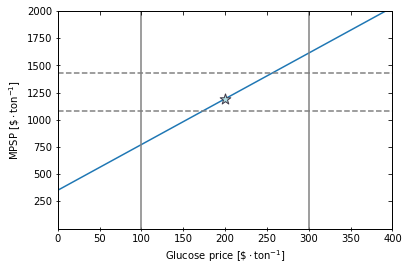

In [4]:
from biosteam import plots
@np.vectorize
def MPSP_at_glucose_price(price):
    ol.glucose.price = price / 907.185
    return get_LAOs_MPSP()

glucose_prices = np.linspace(0, 400)
MPSPs = MPSP_at_glucose_price(glucose_prices)
glucose_price_range = [100, 300]
plt.plot(glucose_prices, MPSPs)
for value in LAO_price_range: plots.plot_horizontal_line(value, linestyle='--')
plots.plot_scatter_points([200], [MPSP_at_glucose_price(200)], marker='*', s=125, color=markercolor,
                            edgecolor=edgecolor)
for price in glucose_price_range: plots.plot_vertical_line(price)
plt.xlabel(f'Glucose price [{MPSP_units}]')
plt.ylabel(f'MPSP [{MPSP_units}]')
plots.style_axis(xticks=np.arange(0, 401, 50),
                 yticks=np.arange(0, 2100, 250),
                 trim_to_limits=True)

In [ ]:
MPSPs

Create contour plots of various metrics vs the conversion in the dehydration reactor and the mass fraction of fatty alcohols in the feed to the dehydration reactor:

In [ ]:
# %% Generate contour data
mass_fractions = np.linspace(0.01, 0.2, 40)
conversions = np.linspace(0.5, 0.999, 40)
mass_fractions, conversions = np.meshgrid(mass_fractions, conversions)
def f(mass_fraction, conversion):
    ol.R102.reaction.X[:] = conversion
    specs.run_specifications(dehydration_reactor_mass_fraction=mass_fraction)
    return np.array([i() for i in olefin_metrics])
f = np.vectorize(f, signature="(),()->(3)")
# specs.load_specifications(fermentation_titer=lab_titer,
#                           fermentation_yield=lab_yield / 100)
# data_lab = f(mass_fractions, conversions)
specs.load_specifications(fermentation_titer=target_titer,
                          fermentation_yield=target_yield / 100,
                          fermentation_productivity=target_productivity,)
data_target = f(mass_fractions, conversions)
percent_mass_fractions = 100 * mass_fractions
percent_conversions = 100 * conversions
#data = np.array([data_lab, data_target])
#data = np.rollaxis(data, 0, 4)

In [ ]:
# %% Plot contours
%matplotlib qt5
data = data_target
xlabel = 'Mass fraction [wt. %]'
ylabel = "Conversion [%]"
xticks = [1, 5, 10, 15, 20]
yticks = [50, 60, 70, 80, 90, 100]
metric_bars = (MetricBar('MPSP', MPSP_units, CABBI_green_colormap(),
                         tickmarks(data[:, :, 0]), 100),
               MetricBar('VOC', VOC_units, plt.cm.get_cmap('magma_r'),
                         tickmarks(data[:, :, 1]), 25),
               MetricBar("FCI", FCI_units,
                         plt.cm.get_cmap('bone_r'),
                         tickmarks(data[:, :, 2]), 20))
fig, axes = plot_contour_1d(percent_mass_fractions, percent_conversions, data, 
                            xlabel, ylabel, xticks, yticks, metric_bars, 
                            fillblack=False)
MSP = data[:, :, 0]
CS = None
for ax in axes[0]:
    plt.sca(ax)
    if not CS:
        CS = plt.contourf(percent_mass_fractions, percent_conversions, MSP, zorder=1e6,
                          levels=LAO_price_range, colors=[shadecolor])
    else:
        CS = plt.contourf(CS, zorder=1e6, levels=LAO_price_range, colors=[shadecolor])
    plt.contour(CS, zorder=1e6, linestyles='dashed', linewidths=1.,
                levels=LAO_price_range, colors=[linecolor])

for ax in axes[0]:
    plt.sca(ax)
    plot_scatter_points([target_mass_fraction], [target_conversion], marker='*', s=125, color=markercolor,
                        edgecolor=edgecolor)
    plot_scatter_points([lab_mass_fraction], [lab_conversion], marker='s', s=75, color=markercolor,
                        edgecolor=edgecolor)

plt.show()